In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scipy.optimize as spo

In [2]:
# read in Howard Covid data for new infections 

# File path for the Excel file
file_path = "FrederickAllYearV2.xlsx"

# List of sheet names from the Excel file
sheet_names = [
    "Summer2021", "Summer2022", "Summer2023", 
    "Winter2021", "Winter2022", "Winter2023"
]

# List of variable names you want for the "New_Cases" lists
list_names = [
    "Summer21", "Summer22", "Summer23", 
    "Winter21", "Winter22", "Winter23"
]

# Loop over each sheet and create a variable for each list of "New_Cases"
for sheet, list_name in zip(sheet_names, list_names):
    # Read the sheet into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    # Extract the "New_Cases" column and convert it into a list
    new_cases_list = df["New_Cases"].tolist()
    
    # Dynamically assign the list to a variable with the desired name
    globals()[list_name] = new_cases_list

# Now we have 6 separate lists as variables:
print(Summer21[:5])
print(Summer22[:5])
print(Summer23[:5])
print(Winter21[:5])
print(Winter22[:5])
print(Winter23[:5])

[68, 42, 50, 44, 36]
[17, 16, 10, 14, 8]
[3, 13, 8, 7, 18]
[46, 32, 52, 44, 46]
[12, 28, 11, 29, 11]
[5, 4, 9, 4, 4]


In [3]:
# Estimate infectious popluation for all read in data - assumes infectious period of 7 days
def update_list(lst):
    updated_lst = []
    
    for i in range(len(lst)):
        # Get the last 6 entries (or fewer) before the current entry
        last_six = lst[max(0, i-6):i]
        updated_entry = lst[i] + sum(last_six)
        updated_lst.append(updated_entry)

    updated_lst = updated_lst[6:]
    return updated_lst
        
summer21_infectious_data = update_list(Summer21)
summer22_infectious_data = update_list(Summer22)
summer23_infectious_data = update_list(Summer23)

winter21_infectious_data = update_list(Winter21)
winter22_infectious_data = update_list(Winter22)
winter23_infectious_data = update_list(Winter23)

In [4]:
# account for 50% underreporting - multiply by 275
winter21data = [x * 2 for x in winter21_infectious_data]
winter22data = [x * 2 for x in winter22_infectious_data]
winter23data = [x * 2 for x in winter23_infectious_data]

summer21data = [x * 2 for x in summer21_infectious_data]
summer22data = [x * 2 for x in summer22_infectious_data]
summer23data = [x * 2 for x in summer23_infectious_data]

print(len(winter21data))
print(len(summer21data))
print(len(winter23data))

151
153
152


In [5]:
# Set up differential equations for the SEIR model (in vector form) using the parameters N, beta, alpha, and gamma.
def dVdt(vector, t, N, alpha, beta, gamma):
    S, E, I, R = vector
    dSdt = -beta * S * I / N
    dEdt = beta * S * I / N - alpha * E
    dIdt = alpha * E - gamma * I
    dRdt = gamma * I
    return dSdt, dEdt, dIdt, dRdt

In [7]:
# Define total population in Howard, N.
N = 287079 

# Define average time of recovery (in days).
recovery = 7

# Calculate recovery rate gamma (in 1/days)
gamma = 1./recovery 

# Set vaccination numbers for Summer21, Summer22, Summer23, Winter21, Winter22, Winter23
# no specific winter 23 vaccination numbers available, assume 92%
summer21vac, summer22vac, summer23vac  = 83363, 193972, 202702  
winter21vac, winter22vac, winter23vac = 170093, 200876, 264113

In [8]:
# Define loss function using SEIR Model ODEs (summer months has 182 days, winter months has 183 days)
def loss_function(alpha_beta, N, gamma, dataI, vac):

    # Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
    # # take into account vaccinated as of June 2021 
    E0, I0, R0 = 0, dataI[0], vac

    # Define initial number of susceptible individuals.
    S0 = N - E0 - I0 - R0 

    # Set up initial conditions vector for S0, E0, I0, R0
    initial_conditions = S0, E0, I0, R0
    
    # Create an array of evenly spaced time values(in days)
    t = np.linspace(0, len(dataI), len(dataI))
    
    # Solve for the differential equations for the SIR model (in vector form) by integrating over the time array t.
    solution = odeint(dVdt, initial_conditions, t, args=(N, alpha_beta[0], alpha_beta[1], gamma))
    # transpose solution array to extract data 
    S, E, I, R = solution.T

    loss = 0
    
    for i in range(len(dataI)):
        data_I = dataI[i]
        model_I = I[i]
        res = (model_I - data_I)**2
        loss += res
    return (loss)

In [9]:
# Initial guess for alpha and beta
initial_guess = [1./5, 0.4]  # Initial guess for alpha and beta

#lowest beta calculated using lowest R number and highest S=N
beta_lowest = (0.5 * N * gamma)/N   
#highest beta calculated using highest R number and lowest S=1
beta_highest = (24 * N * gamma)/1

# Set bounds for alpha and beta
bounds = [(1./9.07, 1./1.09), (beta_lowest, beta_highest)]  # alpha between 1/(9.07 days) and 1/(1.09 days), beta between 0.2 and 2


# Use scipy.optimize.minimize to minimize the loss function for Summer 2021 Alexandria Data and Summer 2022 Alexandria Data
summer21_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, summer21data, summer21vac), method='L-BFGS-B', bounds=bounds)
summer22_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, summer22data, summer22vac), method='L-BFGS-B', bounds=bounds)
summer23_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, summer23data, summer23vac), method='L-BFGS-B', bounds=bounds)

# Print the optimal parameters and minimum loss for summer 2021 Alexandria and summer 2022 Alexandria
print("Optimal alpha and beta for Summer 2021:", summer21_result.x)
print("Optimal alpha and beta for Summer 2022:", summer22_result.x)
print("Optimal alpha and beta for Summer 2023:", summer23_result.x)

# Use scipy.optimize.minimize to minimize the loss function for winter 2021 Alexandria data and winter 2022 Alexandria data
winter21_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, winter21data, winter21vac), method='L-BFGS-B', bounds=bounds)
winter22_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, winter22data, winter22vac), method='L-BFGS-B', bounds=bounds)
winter23_result = spo.minimize(loss_function, initial_guess, args=(N, gamma, winter23data, winter23vac), method='L-BFGS-B', bounds=bounds)

# Print the optimal parameters and minimum loss for winter 2021 Alexandria and winter 2022 Alexandria
print("Optimal alpha and beta for Winter 2021:", winter21_result.x)
print("Optimal alpha and beta for Winter 2022:", winter22_result.x)
print("Optimal alpha and beta for Winter 2023:", winter23_result.x)

Optimal alpha and beta for Summer 2021: [0.11025358 0.20170004]
Optimal alpha and beta for Summer 2022: [0.91743119 0.51161898]
Optimal alpha and beta for Summer 2023: [0.91743119 0.44502192]
Optimal alpha and beta for Winter 2021: [0.65804772 0.52315758]
Optimal alpha and beta for Winter 2022: [0.91743119 0.50742901]
Optimal alpha and beta for Winter 2023: [0.91743119 1.95802576]


In [10]:
#best fit alpha
alpha_fit_winter21 = winter21_result.x[0]
alpha_fit_winter22 = winter22_result.x[0]
alpha_fit_winter23 = winter23_result.x[0]

alpha_fit_summer21 = summer21_result.x[0]
alpha_fit_summer22 = summer22_result.x[0]
alpha_fit_summer23 = summer23_result.x[0]

In [11]:
#best fit beta
beta_fit_winter21 = winter21_result.x[1]
beta_fit_winter22 = winter22_result.x[1]
beta_fit_winter23 = winter23_result.x[1]

beta_fit_summer21 = summer21_result.x[1]
beta_fit_summer22 = summer22_result.x[1]
beta_fit_summer23 = summer23_result.x[1]

In [12]:
#Find best fit I(t) for Summer 2021 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination
E0_summer21, I0_summer21, R0_summer21 = 0, summer21data[0], summer21vac

# Define initial number of susceptible individuals.
S0_summer21 = N - E0_summer21 - I0_summer21 - R0_summer21 

# Set up initial conditions vector for S0, E0, I0, R0
initial_summer21_conditions = S0_summer21, E0_summer21, I0_summer21, R0_summer21

# Create an array of evenly spaced time values(in days)
summer_t = np.linspace(0, len(summer21data), len(summer21data))

# Solve for the differential equations for the SIR model (in vector form) by integrating over the time array t.
summer21_solution = odeint(dVdt, initial_summer21_conditions, summer_t, args=(N, alpha_fit_summer21, beta_fit_summer21, gamma))

# transpose solution array to extract data 
S_summer21, E_summer21, I_summer21, R_summer21 = summer21_solution.T

print(len(summer21data))
print(len(I_summer21))

153
153


In [13]:
#Calculate reproduction number for summer 21 
rep0_summer21 = (beta_fit_summer21 * S0_summer21) / (gamma * N)
print("reproduction number for Summer 21:", rep0_summer21)

reproduction number for Summer 21: 0.9983765326462133


In [14]:
#Find best fit I(t) for Summer 2022 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination
E0_summer22, I0_summer22, R0_summer22 = 0, summer22data[0],  summer22vac

# Define initial number of susceptible individuals.
S0_summer22 = N - E0_summer22 - I0_summer22 - R0_summer22 

# Set up initial conditions vector for S0, E0, I0, R0
initial_summer22_conditions = S0_summer22, E0_summer22, I0_summer22, R0_summer22

# Create an array of evenly spaced time values(in days)
summer22_t = np.linspace(0, len(summer22data), len(summer22data))

# Solve for the differential equations for the SIR model (in vector form) by integrating over the time array t.
summer22_solution = odeint(dVdt, initial_summer22_conditions, summer22_t, args=(N, alpha_fit_summer22, beta_fit_summer22, gamma))

# transpose solution array to extract data 
S_summer22, E_summer22, I_summer22, R_summer22 = summer22_solution.T

In [15]:
#Calculate reproduction number for summer 22
rep0_summer22 = (beta_fit_summer22 * S0_summer22) / (gamma * N)
print("reproduction number for summer 22:", rep0_summer22)

reproduction number for summer 22: 1.1593464028438005


In [16]:
#Find best fit I(t) for Summer 2023 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination
E0_summer23, I0_summer23, R0_summer23 = 0, summer23data[0], summer23vac


# Define initial number of susceptible individuals.
S0_summer23 = N - E0_summer23 - I0_summer23 - R0_summer23 

# Set up initial conditions vector for S0, E0, I0, R0
initial_summer23_conditions = S0_summer23, E0_summer23, I0_summer23, R0_summer23

# Create an array of evenly spaced time values(in days)
summer23_t = np.linspace(0, len(summer23data), len(summer23data))

# Solve for the differential equations for the SIR model (in vector form) by integrating over the time array t.
summer23_solution = odeint(dVdt, initial_summer23_conditions, summer23_t, args=(N, alpha_fit_summer23, beta_fit_summer23, gamma))

# transpose solution array to extract data 
S_summer23, E_summer23, I_summer23, R_summer23 = summer23_solution.T

In [17]:
#Calculate reproduction number for summer 23
rep0_summer23 = (beta_fit_summer23 * S0_summer23) / (gamma * N)
print("reproduction number for summer 23:", rep0_summer23)

reproduction number for summer 23: 0.9139428461786117


In [18]:
#Find best fit I(t) for Winter 2021-22 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination 
E0_winter21, I0_winter21, R0_winter21 = 0, winter21data[0], winter21vac

# Define initial number of susceptible individuals.
S0_winter21 = N - E0_winter21 - I0_winter21 - R0_winter21 

# Set up initial conditions vector for S0, E0, I0, R0
initial_winter21_conditions = S0_winter21, E0_winter21, I0_winter21, R0_winter21
# Create an array of evenly spaced time values(in days)
winter21_t = np.linspace(0, len(winter21data), len(winter21data))
# Solve for the differential equations for the SIR model (in vector form) by integrating over the time array t.
solution_winter21 = odeint(dVdt, initial_winter21_conditions, winter21_t, args=(N, alpha_fit_winter21, beta_fit_winter21, gamma))
# transpose solution array to extract data 
S_winter21, E_winter21, I_winter21, R_winter21 = solution_winter21.T
print(len(I_winter21))
print(len(winter21data))

151
151


In [19]:
#Calculate reproduction number for winter 21 
rep0_winter21 = (beta_fit_winter21 * S0_winter21) / (gamma * N)
print("reproduction number for winter 21:", rep0_winter21)

reproduction number for winter 21: 1.4852566094228892


In [20]:
#Find best fit I(t) for Winter 2022-23 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination 
E0_winter22, I0_winter22, R0_winter22 = 0, winter22data[0], winter22vac

# Define initial number of susceptible individuals.
S0_winter22 = N - E0_winter22 - I0_winter22 - R0_winter22 

# Set up initial conditions vector for S0, E0, I0, R0
initial_winter22_conditions = S0_winter22, E0_winter22, I0_winter22, R0_winter22
# Create an array of evenly spaced time values(in days)
winter22_t = np.linspace(0, len(winter22data), len(winter22data))
# Solve for the differential equations for the SEIR model (in vector form) by integrating over the time array t.T-
solution_winter22 = odeint(dVdt, initial_winter22_conditions, winter22_t, args=(N, alpha_fit_winter22, beta_fit_winter22, gamma))
# transpose solution array to extract data 
S_winter22, E_winter22, I_winter22, R_winter22 = solution_winter22.T

print(len(I_winter22))
print(len(winter22data))

151
151


In [21]:
#Calculate reproduction number for winter 22 
rep0_winter22 = (beta_fit_winter22 * S0_winter22) / (gamma * N)
print("reproduction number for Winter 22:", rep0_winter22)

reproduction number for Winter 22: 1.0632909061310347


In [22]:
#Find best fit I(t) for Winter 2023-24 Frederick Data
# Define initial number of exposed, infected, and recovered individuals: E0, I0, R0.
# take into account vaccination 
E0_winter23, I0_winter23, R0_winter23 = 0, winter23data[0], winter23vac

# Define initial number of susceptible individuals.
S0_winter23 = N - E0_winter23 - I0_winter23 - R0_winter23 

# Set up initial conditions vector for S0, E0, I0, R0
initial_winter23_conditions = S0_winter23, E0_winter23, I0_winter23, R0_winter23

# Create an array of evenly spaced time values(in days)
winter23_t = np.linspace(0, len(winter23data), len(winter23data))
# Solve for the differential equations for the SEIR model (in vector form) by integrating over the time array t.
solution_winter23 = odeint(dVdt, initial_winter23_conditions, winter23_t, args=(N, alpha_fit_winter23, beta_fit_winter23, gamma))
# transpose solution array to extract data 
S_winter23, E_winter23, I_winter23, R_winter23 = solution_winter23.T

#print(len(I_winter23))
print(len(I_winter23))
print(len(winter23data))

152
152


In [23]:
#Calculate reproduction number for winter 23 
rep0_winter23 = (beta_fit_winter23 * S0_winter23) / (gamma * N)
print("reproduction number for Winter 23:", rep0_winter23)

reproduction number for Winter 23: 1.0923731991848311


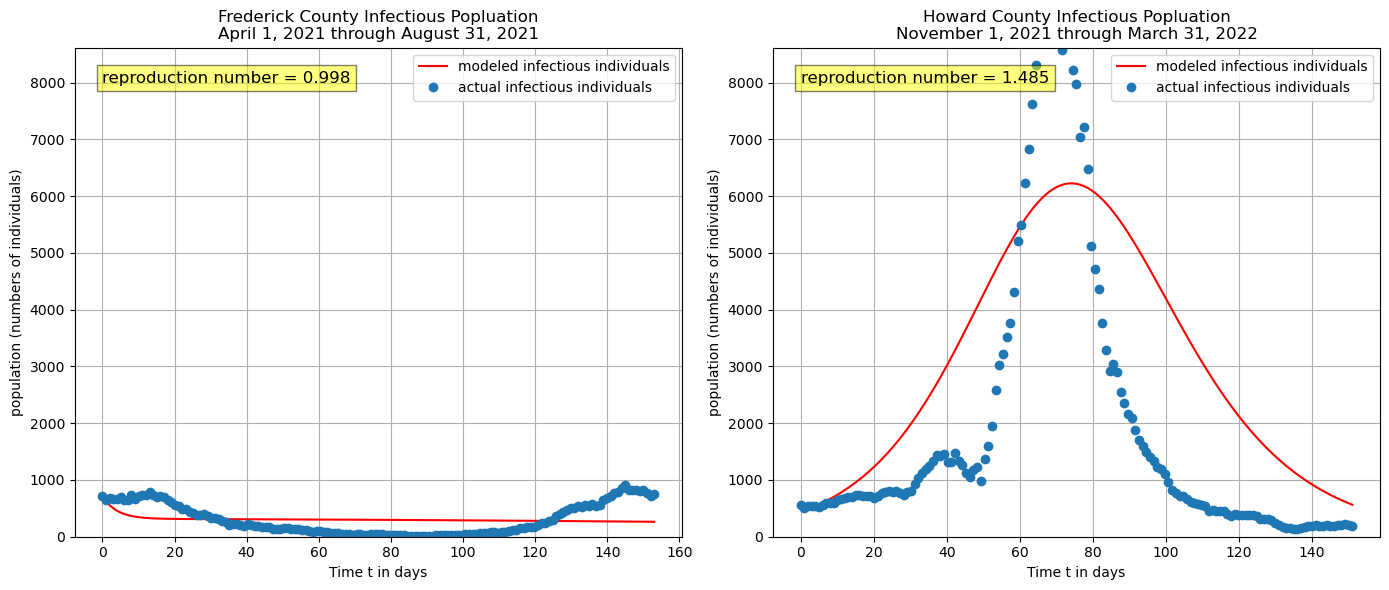

In [24]:
#Plot Summer21 and Winter21/22 side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot I(t) and Frederick data for Summer 2021-22 on same grid
ax1.grid()
ax1.set_title('Frederick County Infectious Popluation\nApril 1, 2021 through August 31, 2021')
ax1.plot(summer_t, I_summer21, 'r', label='modeled infectious individuals')
ax1.plot(summer_t, summer21data, 'o', label='actual infectious individuals')
ax1.set_xlabel('Time t in days')
ax1.set_ylabel('population (numbers of individuals)')
ax1.set_ylim([0,0.03*N])
ax1.legend()

text_str = f'reproduction number = {rep0_summer21:.3f}'
ax1.text(0, 8000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))

# plot I(t) and Howard data for Winter 2021-22 on same grid
ax2.grid()
ax2.set_title('Howard County Infectious Popluation\nNovember 1, 2021 through March 31, 2022')
ax2.plot(winter21_t, I_winter21, 'r', label='modeled infectious individuals')
ax2.plot(winter21_t, winter21data, 'o', label='actual infectious individuals')
ax2.set_xlabel('Time t in days')
ax2.set_ylabel('population (numbers of individuals)')
ax2.set_ylim([0,0.03*N])
ax2.legend()

text_str = f'reproduction number = {rep0_winter21:.3f}'
ax2.text(0, 8000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))
plt.tight_layout() 
plt.show();

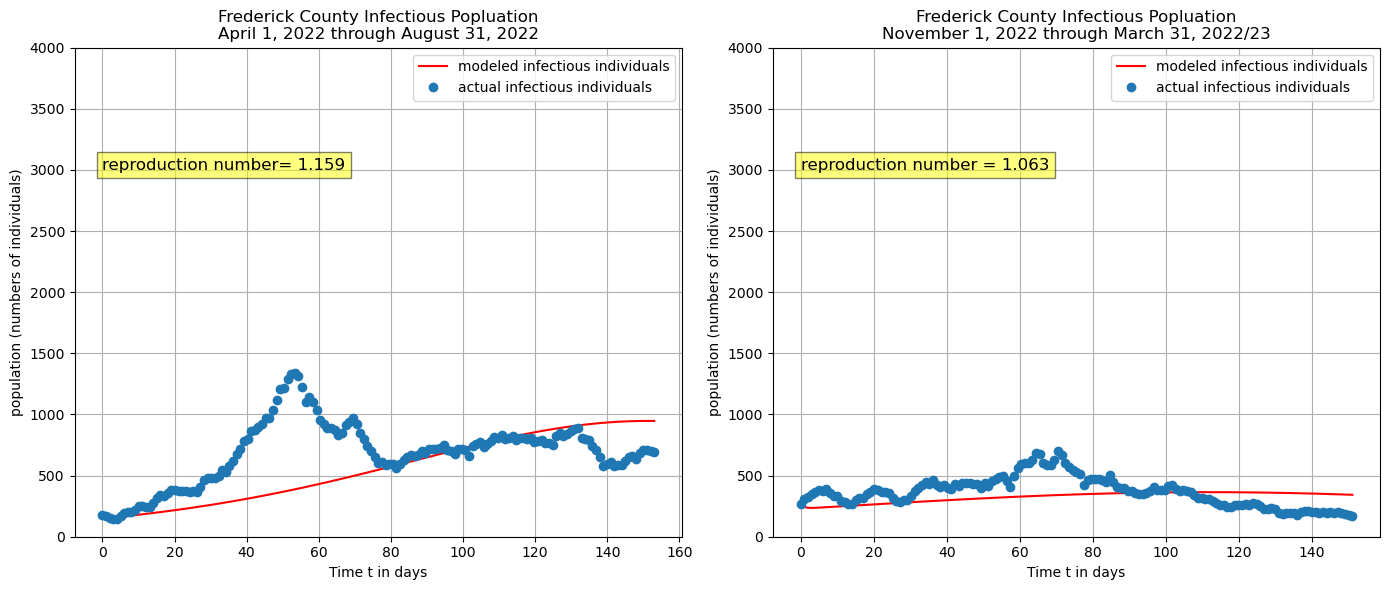

In [25]:
#Plot Summer22 and Winter22/23 side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot I(t) and Frederick data for Summer 2022-23 on same grid
ax1.grid()
ax1.set_title('Frederick County Infectious Popluation\nApril 1, 2022 through August 31, 2022')
ax1.plot(summer22_t, I_summer22, 'r', label='modeled infectious individuals')
ax1.plot(summer22_t, summer22data, 'o', label='actual infectious individuals')
ax1.set_xlabel('Time t in days')
ax1.set_ylabel('population (numbers of individuals)')
ax1.set_ylim([0, 4000])
ax1.legend()

text_str = f'reproduction number= {rep0_summer22:.3f}'
ax1.text(0, 3000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))


# plot I(t) and Frederick data for Winter 2022-23 on same grid
ax2.grid()
ax2.set_title('Frederick County Infectious Popluation\nNovember 1, 2022 through March 31, 2022/23')
ax2.plot(winter22_t, I_winter22, 'r', label='modeled infectious individuals')
ax2.plot(winter22_t, winter22data, 'o', label='actual infectious individuals')
ax2.set_xlabel('Time t in days')
ax2.set_ylabel('population (numbers of individuals)')
ax2.set_ylim([0,4000])
ax2.legend()

text_str = f'reproduction number = {rep0_winter22:.3f}'
ax2.text(0, 3000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))

plt.tight_layout() 
plt.show();

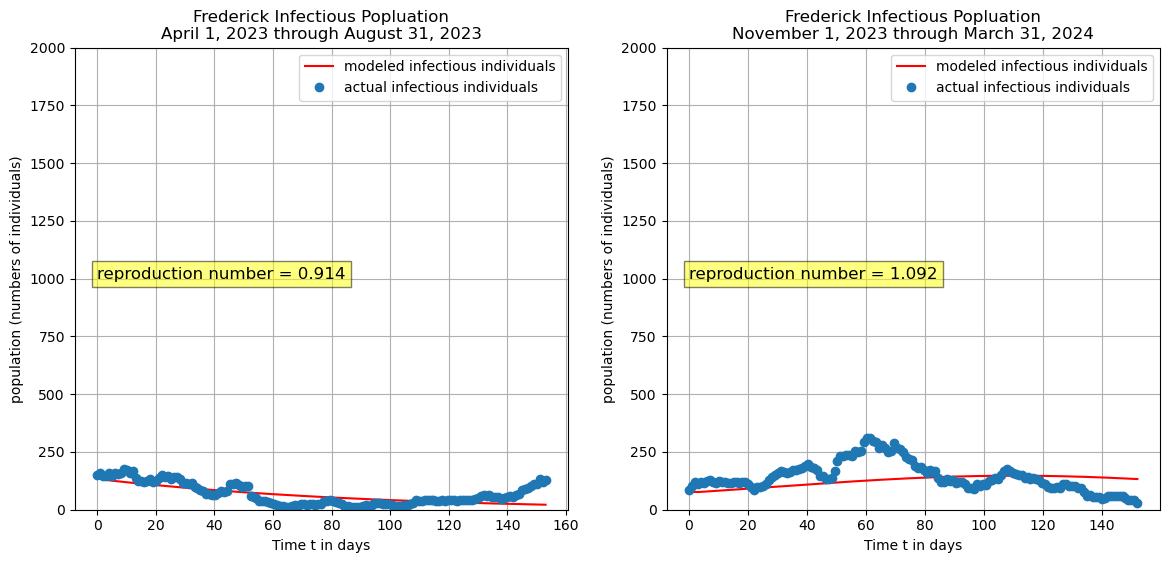

In [26]:
#Plot Summer21 and Winter23/24 side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# plot I(t) and Frederick data for Summer 2023-24 on same grid
ax1.grid()
ax1.set_title('Frederick Infectious Popluation\nApril 1, 2023 through August 31, 2023')
ax1.plot(summer23_t, I_summer23, 'r', label='modeled infectious individuals')
ax1.plot(summer23_t, summer23data, 'o', label='actual infectious individuals')
ax1.set_xlabel('Time t in days')
ax1.set_ylabel('population (numbers of individuals)')
ax1.set_ylim([0,2000])
ax1.legend()

text_str = f'reproduction number = {rep0_summer23:.3f}'
ax1.text(0, 1000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))


# plot I(t) and Frederick data for Winter 2021-22 on same grid
ax2.grid()
ax2.set_title('Frederick Infectious Popluation\nNovember 1, 2023 through March 31, 2024')
ax2.plot(winter23_t, I_winter23, 'r', label='modeled infectious individuals')
ax2.plot(winter23_t, winter23data, 'o', label='actual infectious individuals')
ax2.set_xlabel('Time t in days')
ax2.set_ylabel('population (numbers of individuals)')
ax2.set_ylim([0, 2000])
ax2.legend()

text_str = f'reproduction number = {rep0_winter23:.3f}'
ax2.text(0, 1000, text_str, fontsize=12, color='black', bbox=dict(facecolor='yellow', alpha=0.5))

plt.tight_layout
plt.show();